# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

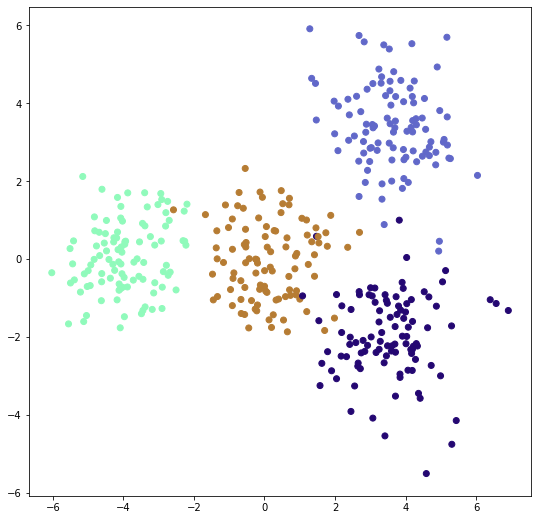

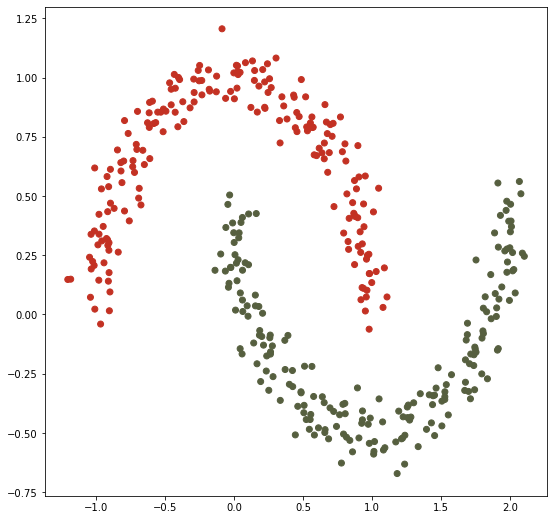

In [31]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [32]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = []

    
    
    def random_centroids(self, X: np.array):
        min_bounds, max_bounds = np.amin(X, axis = 0), np.amax(X, axis = 0)
        self.centroids = np.random.rand(self.n_clusters, X.shape[1])
        for i in range(self.n_clusters):
            self.centroids[i] = min_bounds + (max_bounds - min_bounds) * self.centroids[i]
        
        
    
    def random_sample_centroids(self, X: np.array):
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
    
    def kpp_centroids(self, X: np.array):
        self.centroids = np.zeros((self.n_clusters, X.shape[1]))
        self.centroids[0] = np.random.choice(X.shape[0], 1)
        lst = [i for i in range(X.shape[0])]
        for i in range(1, self.n_clusters):
            dists = np.zeros((X.shape[0], i))
            for j in range(X.shape[0]):
                dists[j] = np.linalg.norm(self.centroids[:i] - X[j])
            M = np.amin(dists, axis = 1).tolist()
            ind = random.choices(lst, cum_weights = M)
            self.centroids[i] = X[ind]
            
        
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        if self.init == "random":
            self.random_centroids(X)
        elif self.init == "sample":
            self.random_sample_centroids(X)
        elif self.init =='k-means++':
            self.kpp_centroids(X)
        
        pred = np.zeros(X.shape[0])
        for _ in range(self.max_iter):
            new_pred = self.predict(X)
            if np.all(new_pred == pred):
                break
            else:
                for i in range(self.n_clusters):
                    if np.sum(new_pred == i):
                        # если получился не пустой класстер
                        self.centroids[i] = np.mean(X[new_pred == i], axis = 0)
                    else:
                        # иначе инициализируем заново
                        self.centroids[i] = X[np.random.choice(X.shape[0], 1)]
            pred = new_pred
        

    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        
        dists = np.zeros((X.shape[0], self.centroids.shape[0]))
        for i in range(X.shape[0]):
            dists[i] = np.linalg.norm(self.centroids - X[i], axis = 1)
        res = np.argmin(dists, axis = 1)
        return res


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

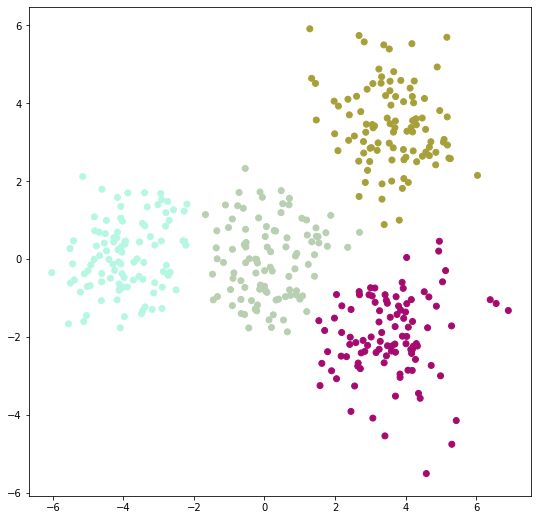

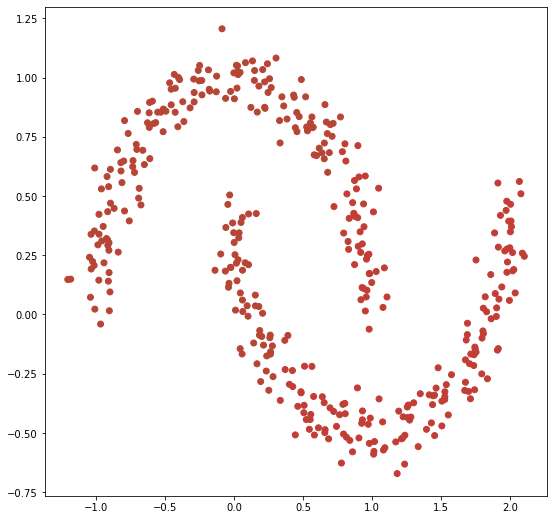

In [33]:
kmeans = KMeans(n_clusters=4, init = 'k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init = 'k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [34]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        

        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        used = [False] * (X.shape[0])
        edges = tree.query_radius(X, r = self.eps)
        clst = -1    # current number of cluster
        label = -np.ones(X.shape[0])    # -1 - noise
        for i in range(X.shape[0]):
            if used[i]:
                continue
    
            used[i] = True
            if edges[i].shape[0] < self.min_samples:    # если мало соседей
                continue
            
            # а сейчас bfs
            clst += 1
            label[i] = clst
            q = deque([i])
            while q:
                k = q.popleft()
                for j in edges[k]:
                    if not used[j]:
                        used[j] = True; label[j] = clst
                        if edges[j].shape[0] >= self.min_samples:    # если достаточно соседей
                            q.append(j)
                    # если эта вершина была посещена, но если ее не добавили в кластер, то она была распознана как шум
                    if label[j] == 0:
                        label[j] = clst        

        label[label == -1] = clst + 1    # шум будет последним
        return label.astype(int)
   
        
        
        
        
        
    

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

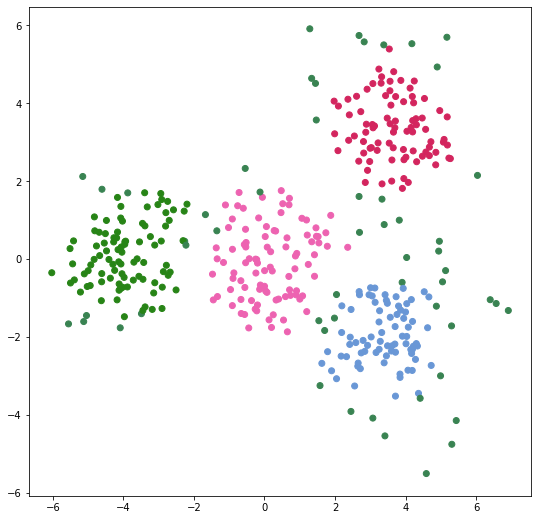

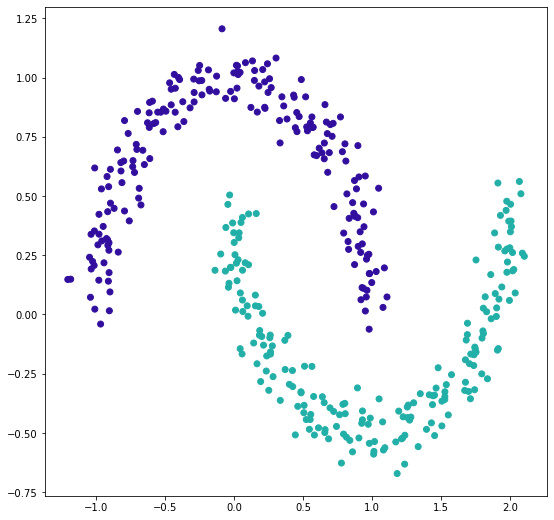

In [37]:
dbscan = DBScan(min_samples=8, eps=0.62)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(min_samples=7, eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [8]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread(path)
    # image_rgb_norm = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(float) / 255
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb_norm = cv2.normalize(image_rgb, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return image_rgb_norm
    
    
    raise NotImplementedError()

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    # image = cv2.imwrite(path, (image * 255).astype(int))
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image_bgr)

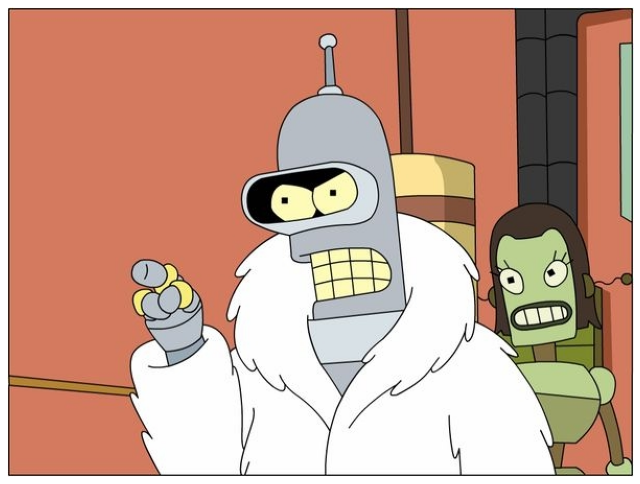

In [9]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [10]:
def clusterize_image(image, n_clusters=4, init="random"):
    
    re_image = image.reshape((-1, 3))
    kmean = KMeans(n_clusters=n_clusters, max_iter = 16, init=init)
    
    # flattened_image = re_image[np.arange(re_image.shape[0]) % 4 == 0]   # сжимаем
    # kmean.fit(flattened_image)   # учимся на данных поменьше
    
    kmean.fit(re_image)
    cluster_colors = kmean.centroids # color of each cluster
    clusters = kmean.predict(re_image) # Cluster labels for each pixel in flattened image
    recolored = np.zeros(re_image.shape) # Image with pixel colors assigned to corresponding cluster colors
    for i, color in enumerate(np.unique(clusters)):
        recolored[clusters == color] = cluster_colors[i]
    
    clusters_statistics(re_image, cluster_colors, clusters) # Very slow (:
    return recolored.reshape(image.shape)

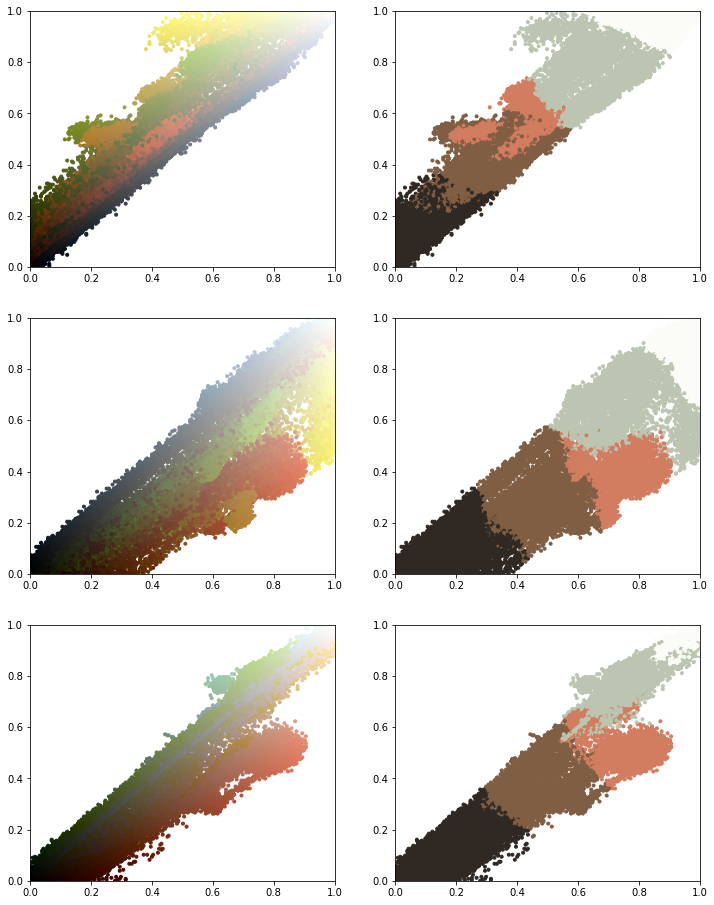

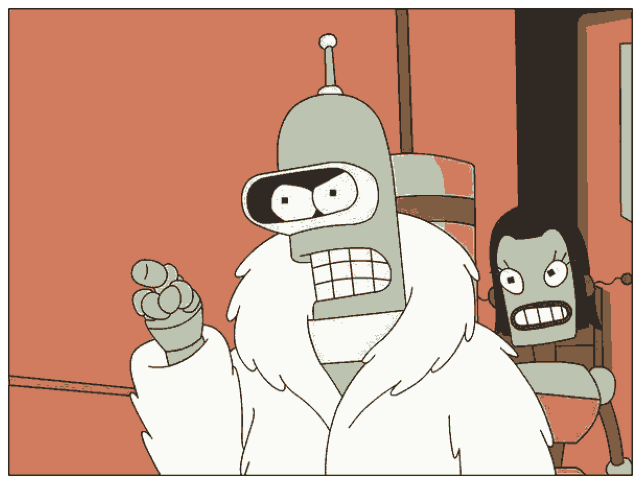

CPU times: user 1min 34s, sys: 764 ms, total: 1min 35s
Wall time: 1min 35s


In [11]:
%%time
n = 5
image = read_image("./image.png")
result = clusterize_image(image, n_clusters=n, init="random")
show_image(result)
save_image(result, "result.png")